In [68]:
%matplotlib inline
import matplotlib.pyplot as plt

In [69]:
# import numpy as np

In [70]:
from numpy import int0, array, asarray, zeros, reshape, double, arange, \
                  ma, log10, diff, mean, flipud, floor, pi, sqrt, size, fliplr, meshgrid, exp, sin, cos, radians, ceil, round

In [71]:
!rm -rf /tmp/*
!find /home/mag/Documents/repos/solab/PySOL/pySAR/ -name '*.pyc' -delete
!find /home/mag/Documents/repos/solab/PySOL/cerbere/ -name '*.pyc' -delete

import sys
sys.path.append('/home/mag/Documents/repos/solab/PySOL/pySAR/')
sys.path.append('/home/mag/Documents/repos/solab/PySOL/cerbere/')

# reload(sar.utils.factory)
# reload(sar.data.sarimage)

from sar.utils.factory import sarmapper
from sar.data.sarimage import SARImage

# Unzipped
pn  = '/media/SOLabNFS2/tmp/different_SAR/sentinel-1/S1A_IW_GRDH_1SDV_20150519T213443_20150519T213512_005996_007BA4_89FC.SAFE/measurement/'
fn = 's1a-iw-grd-vh-20150519t213443-20150519t213512-005996-007ba4-002.tiff'

# Zipped
pn  = '/media/SOLabNFS2/tmp/different_SAR/sentinel-1/Ania_Ladoga_29_May_2015/'
fn = 'S1A_EW_GRDM_1SDH_20150517T153117_20150517T153221_005963_007AED_56B0.zip'

from zipfile import ZipFile
import tempfile
import shutil
try:
    tmpFldr = tempfile.mkdtemp()  # create tmpdir
    with ZipFile(pn+fn, "r") as zf:
        for name in zf.namelist():
            localFilePath = zf.extract(name, tmpFldr)
#             print localFilePath
    tiffs = [s for s in zf.namelist() if ".tiff" in s]
    zf.close()
except Exception:
    Exception.message

In [72]:
# Construct filename to process
if len(tiffs) == 2:
    fileName = [tmpFldr + '/' + tiffs[0], tmpFldr + '/' + tiffs[1]]
else:
    filename = tmpFldr + '/' + tiffs

sarmp = sarmapper(fileName[0])
sarim = SARImage(sarmp)
spacing_m = int0(200)
spacing = int0(sarim.meters2pixels(spacing_m))
# ssr = sarim.get_data('roughness', spacing=spacing)
# sigma0 = sarim.get_data('sigma0', spacing=spacing)

In [73]:
# shutil.rmtree(tmpFldr)  # delete directory
# !rm -rf /tmp/*
# %ls /tmp

### NonInteractive Plot

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10


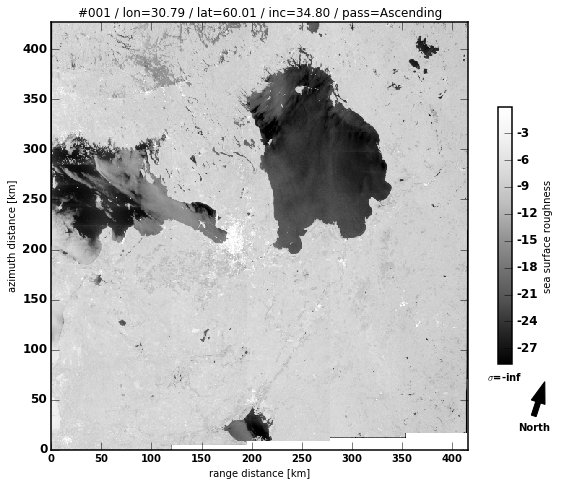

In [74]:
from scipy.stats import scoreatpercentile
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# %matplotlib qt
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()

plt.close('all')
vmin = None
vmax = None

spacing_ra = ceil(sarim.get_info('number_of_samples')/600.)
spacing_ra_m = sarim.pixels2meters(spacing_ra)[1]
spacing = int0(round(sarim.meters2pixels(spacing_ra_m)))
spacing_m = sarim.pixels2meters(spacing)
sigma0 = sarim.get_data('sigma0', spacing=spacing)
sigma0 = 10*log10(sigma0)
lon = sarim.get_data('lon', midrange=True, midazimuth=True)[0, 0]
lat = sarim.get_data('lat', midrange=True, midazimuth=True)[0, 0]
inc = sarim.get_data('incidence', midrange=True, midazimuth=True)[0, 0]
heading = sarim.get_info('platform_heading')
north = 90 + heading # north dir in image
im_num = sarim.get_info('image_number')
dist = (array(sigma0.shape)-1)*spacing_m/1000.
if vmin is None:
    vmin = scoreatpercentile(sigma0[25:-25, 25:-25], 0.1)
if vmax is None:
    vmax = scoreatpercentile(sigma0[25:-25, 25:-25], 99.9)
if sarim.get_info('pass') == 'Descending':
    sigma0 = sigma0[::-1, ::-1]
    north = north+180

# Make figure
dpi = 100
imsize = array(sigma0.shape[::-1])
margin = array(((900-imsize[0])/2, 60))
figsize = array((900, imsize[1]+2*margin[1]))
imsizeN = imsize.astype('float')/figsize
marginN = margin.astype('float')/figsize

fig = plt.figure(figsize=figsize.astype('float')/dpi, dpi=dpi)
imax = fig.add_axes([marginN[0], marginN[1], imsizeN[0], imsizeN[1]])
imax.set_xlim(0, dist[1])
imax.set_ylim(0, dist[0])
plt.imshow(sigma0, origin='lower', interpolation='nearest', vmin=vmin,
            vmax=vmax, cmap=cm.get_cmap('Greys_r'),
            extent=[0, dist[1], 0, dist[0]], aspect='auto')
imax.set_xlabel('range distance [km]')
imax.set_ylabel('azimuth distance [km]')
tit = '#%03i / lon=%.2f / lat=%.2f / inc=%.2f / pass=%s' % (im_num, lon, lat, inc, sarim.get_info('pass'))
imax.set_title(tit)

# Add colorbar
cbax = fig.add_axes([1-0.75*marginN[0], .25, 20./figsize[0], .50])
plt.colorbar(label='sea surface roughness', cax=cbax, format='%i')
meanstr = r'$\sigma$=%.1f' % sigma0.mean()
cbax.text(0.5, -0.025, meanstr, ha='center', va='top')

# Add north
cpsizeN = (margin[0]-margin[1])/figsize.astype('float')
cpax = fig.add_axes([1-0.75*marginN[0], 0.15-cpsizeN[1]/2, cpsizeN[0], cpsizeN[1]])
plt.arrow(.5, .5, .5*cos(north*pi/180),
          .5*sin(north*pi/180), facecolor='black',
          width=0.07, length_includes_head=True,
          head_width=0.2, head_length=0.3)
plt.annotate('North', (.5, .4), ha='center', va='top')
cpax.set_axis_off()

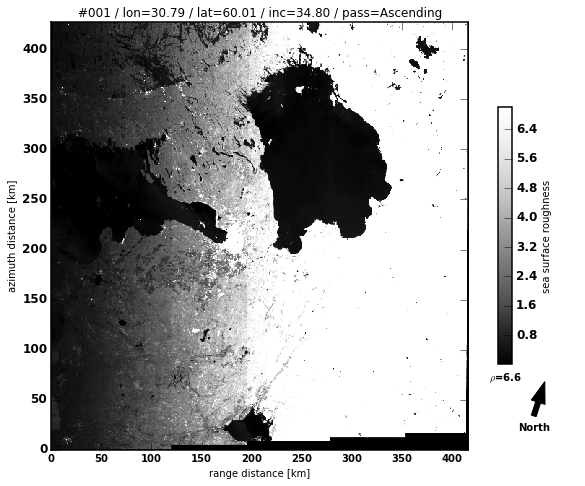

In [75]:
from scipy.stats import scoreatpercentile
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

vmin = None
vmax = 7
cmap='Greys_r'

spacing_ra = ceil(sarim.get_info('number_of_samples')/600.)
spacing_ra_m = sarim.pixels2meters(spacing_ra)[1]
spacing = int0(round(sarim.meters2pixels(spacing_ra_m)))
spacing_m = sarim.pixels2meters(spacing)
ssr = sarim.get_data('roughness', spacing=spacing)
lon = sarim.get_data('lon', midrange=True, midazimuth=True)[0, 0]
lat = sarim.get_data('lat', midrange=True, midazimuth=True)[0, 0]
inc = sarim.get_data('incidence', midrange=True, midazimuth=True)[0, 0]
heading = sarim.get_info('platform_heading')
north = 90 + heading # north dir in image
im_num = sarim.get_info('image_number')
dist = (array(ssr.shape)-1)*spacing_m/1000.
if vmin is None:
    vmin = scoreatpercentile(ssr[25:-25, 25:-25], 0.1)
if vmax is None:
    vmax = scoreatpercentile(ssr[25:-25, 25:-25], 99.9)
if sarim.get_info('pass') == 'Descending':
    ssr = ssr[::-1, ::-1]
    north = north+180

# Make figure
dpi = 100
imsize = array(ssr.shape[::-1])
margin = array(((900-imsize[0])/2, 60))
figsize = array((900, imsize[1]+2*margin[1]))
imsizeN = imsize.astype('float')/figsize
marginN = margin.astype('float')/figsize

fig = plt.figure(figsize=figsize.astype('float')/dpi, dpi=dpi)
imax = fig.add_axes([marginN[0], marginN[1], imsizeN[0], imsizeN[1]])
imax.set_xlim(0, dist[1])
imax.set_ylim(0, dist[0])
plt.imshow(ssr, origin='lower', interpolation='nearest', vmin=vmin,
            vmax=vmax,
            extent=[0, dist[1], 0, dist[0]], aspect='auto')
plt.set_cmap(cmap) 
imax.set_xlabel('range distance [km]')
imax.set_ylabel('azimuth distance [km]')
tit = '#%03i / lon=%.2f / lat=%.2f / inc=%.2f / pass=%s' % (im_num, lon, lat, inc, sarim.get_info('pass'))
imax.set_title(tit)

# Add colorbar
cbax = fig.add_axes([1-0.75*marginN[0], .25, 20./figsize[0], .50])
plt.colorbar(label='sea surface roughness', cax=cbax, format='%.1f')
meanstr = r'$\rho$=%.1f' % ssr.mean()
cbax.text(0.5, -0.025, meanstr, ha='center', va='top')

# Add north
cpsizeN = (margin[0]-margin[1])/figsize.astype('float')
cpax = fig.add_axes([1-0.75*marginN[0], 0.15-cpsizeN[1]/2, cpsizeN[0], cpsizeN[1]])
plt.arrow(.5, .5, .5*cos(north*pi/180),
          .5*sin(north*pi/180), facecolor='black',
          width=0.07, length_includes_head=True,
          head_width=0.2, head_length=0.3)
plt.annotate('North', (.5, .4), ha='center', va='top')
cpax.set_axis_off()

In [77]:
print heading, 90+heading, 90+180+heading

-17.924342578 72.075657422 252.075657422


In [9]:
sarim.get_datanames()

['lon',
 'lat',
 'incidence',
 'elevation',
 'digital_number',
 'gamma0_lut',
 'beta0_lut',
 'sigma0_lut',
 'gamma0',
 'beta0',
 'sigma0',
 'complex',
 'azimuth_time',
 'slant_range_time',
 'doppler_centroid']

In [66]:
def extractZip2memory(input_zip):
    input_zip=ZipFile(input_zip, 'r')
    return {name: StringIO(input_zip.read(name)) for name in input_zip.namelist()[:-1]}
zf.namelist()

['S1A_EW_GRDM_1SDH_20150517T153117_20150517T153221_005963_007AED_56B0.SAFE/',
 'S1A_EW_GRDM_1SDH_20150517T153117_20150517T153221_005963_007AED_56B0.SAFE/S1A_EW_GRDM_1SDH_20150517T153117_20150517T153221_005963_007AED_56B0.SAFE-report-20150517T174938.pdf',
 'S1A_EW_GRDM_1SDH_20150517T153117_20150517T153221_005963_007AED_56B0.SAFE/support/',
 'S1A_EW_GRDM_1SDH_20150517T153117_20150517T153221_005963_007AED_56B0.SAFE/support/s1-level-1-calibration.xsd',
 'S1A_EW_GRDM_1SDH_20150517T153117_20150517T153221_005963_007AED_56B0.SAFE/support/s1-level-1-product.xsd',
 'S1A_EW_GRDM_1SDH_20150517T153117_20150517T153221_005963_007AED_56B0.SAFE/support/s1-object-types.xsd',
 'S1A_EW_GRDM_1SDH_20150517T153117_20150517T153221_005963_007AED_56B0.SAFE/support/s1-level-1-noise.xsd',
 'S1A_EW_GRDM_1SDH_20150517T153117_20150517T153221_005963_007AED_56B0.SAFE/support/s1-map-overlay.xsd',
 'S1A_EW_GRDM_1SDH_20150517T153117_20150517T153221_005963_007AED_56B0.SAFE/support/s1-level-1-quicklook.xsd',
 'S1A_EW_GRDM_

### Interactive Plot - doesn't work

In [37]:
dpi = 300
figsize = array([3, 3*double(ssr.shape[0])/double(ssr.shape[1])])*dpi
imsize = array(ssr.shape[::-1])
margin = array(((figsize[0]-imsize[0])/2, 60))
imsizeN = imsize.astype('float')/figsize
marginN = margin.astype('float')/figsize

print figsize, imsizeN, imsize, marginN, margin

dpi = 300
imsize = array(ssr.shape[::-1])
margin = array(((900-imsize[0])/2, 60))
figsize = array((900, imsize[1]+2*margin[1]))
imsizeN = imsize.astype('float')/figsize
marginN = margin.astype('float')/figsize

print figsize, imsizeN, imsize, marginN, margin

imsize = array((1200,1200*ssr.shape[1]/ssr.shape[0]))
margin = array(((900-imsize[0])/2, 60))
figsize = array((900, imsize[1]+2*margin[1]))
imsizeN = imsize.astype('float')/figsize
marginN = margin.astype('float')/figsize
fig = plt.figure(figsize=figsize.astype('float')/dpi, dpi=dpi)

margin = array(((900-imsize[0])/2, 60))
figsize = array((900, imsize[1]+2*margin[1]))

array([2087, 2675])

In [ ]:
from scipy.stats import scoreatpercentile
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

vmin = None
vmax = None

# spacing_ra = ceil(sarim.get_info('number_of_samples')/2400.)
# spacing_ra_m = sarim.pixels2meters(spacing_ra)[1]
# spacing = round(sarim.meters2pixels(spacing_ra_m))
# spacing_m = sarim.pixels2meters(spacing)
ssr = sarim.get_data('roughness', spacing=spacing)
lon = sarim.get_data('lon', midrange=True, midazimuth=True)[0, 0]
lat = sarim.get_data('lat', midrange=True, midazimuth=True)[0, 0]
inc = sarim.get_data('incidence', midrange=True, midazimuth=True)[0, 0]
heading = sarim.get_info('platform_heading')
north = 90 + heading # north dir in image
im_num = sarim.get_info('image_number')
dist = (array(ssr.shape)-1)*spacing_m/1000.
if vmin is None:
    vmin = scoreatpercentile(ssr[25:-25, 25:-25], 0.1)
if vmax is None:
    vmax = scoreatpercentile(ssr[25:-25, 25:-25], 99.9)
if sarim.get_info('pass') == 'Descending':
    ssr = ssr[::-1, ::-1]
    north = north+180

def ntrctv_imshow(vmin=None, vmax=None, cmap='Greys_r', crop='[:,:]'):
    # Make figure
    dpi = 300
    imsize = array(ssr.shape[::-1])
    margin = array(((900-imsize[0])/2, 60))
    figsize = array((900, imsize[1]+2*margin[1]))
    imsizeN = imsize.astype('float')/figsize
    marginN = margin.astype('float')/figsize


#     figsize = array([16, 16*double(ssr.shape[0])/double(ssr.shape[1])])*dpi
#     imsize = array(ssr.shape[::-1])
#     margin = array(((figsize[0]-imsize[0])/2, 60))
#     imsizeN = imsize.astype('float')/figsize
#     marginN = margin.astype('float')/figsize

    fig = plt.figure(figsize=figsize.astype('float')/dpi, dpi=dpi)
    imax = fig.add_axes([marginN[0], marginN[1], imsizeN[0], imsizeN[1]])
    imax.set_xlim(0, dist[1])
    imax.set_ylim(0, dist[0])
    plt.imshow(eval("ssr"+str(crop)), origin='lower', interpolation='nearest', vmin=vmin,
                vmax=vmax,
                extent=[0, dist[1], 0, dist[0]], aspect='auto')
    plt.set_cmap(cmap) 
    imax.set_xlabel('range distance [km]')
    imax.set_ylabel('azimuth distance [km]')
    tit = '#%03i / lon=%.2f / lat=%.2f / inc=%.2f / pass=%s' % (im_num, lon, lat, inc, sarim.get_info('pass'))
    imax.set_title(tit)

    # Add colorbar
    cbax = fig.add_axes([1-0.75*marginN[0], .25, 20./figsize[0], .50])
    plt.colorbar(label='sea surface roughness', cax=cbax, format='%.1f')
    meanstr = r'$\rho$=%.1f' % ssr.mean()
    cbax.text(0.5, -0.025, meanstr, ha='center', va='top')

    # Add north
    cpsizeN = (margin[0]-margin[1])/figsize.astype('float')
    cpax = fig.add_axes([1-0.75*marginN[0], 0.15-cpsizeN[1]/2, cpsizeN[0], cpsizeN[1]])
    plt.arrow(.5, .5, .5*cos(north*pi/180),
              .5*sin(north*pi/180), facecolor='black',
              width=0.07, length_includes_head=True,
              head_width=0.2, head_length=0.3)
    plt.annotate('North', (.5, .4), ha='center', va='top')
    cpax.set_axis_off()



from IPython.html import widgets

ntrctv = widgets.interact(ntrctv_imshow, \
                 vmin=widgets.FloatSliderWidget(min=0, max=5, value=vmin, step=0.2), \
                 vmax=widgets.FloatSliderWidget(min=0, max=5, value=vmax, step=0.2), \
                 cmap = ['Greys_r', 'bone', 'RdBu_r'], crop='[:,:]');